In computer science and operations research, a genetic algorithm (GA) is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms (EA). Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems by relying on biologically inspired operators such as mutation, crossover and selection.John Holland introduced genetic algorithms in 1960 based on the concept of Darwin’s theory of evolution; his student David E. Goldberg further extended GA in 1989

https://en.wikipedia.org/wiki/Genetic_algorithm

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import numpy as np
import random
import pickle as pkl

import matplotlib.pyplot as plt

Using TensorFlow backend.


<h1 id="dataset" style="color:#024434; background:#f4684b; border:0.5px dotted;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [2]:
dataset = pd.read_csv('product features.csv')
y_train = dataset['class']
x_train = dataset.drop(labels =['class'],axis=1)

ohe = OneHotEncoder()
le = LabelEncoder()

cols = x_train.columns.values
for col in cols:
    x_train[col] = le.fit_transform(x_train[col])

y_train = le.fit_transform(y_train)

ohe = OneHotEncoder(categorical_features='all')
x_train = ohe.fit_transform(x_train).toarray()
sc = StandardScaler()
x_train = sc.fit_transform(x_train)


x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size = 0.30, random_state = 42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, test_size = 0.50, random_state = 42)



<h1 id="aan-architecture" style="color:#024434; background:#f4684b; border:0.5px dotted;"> 
    <center>Artificial Neural Network Architecture
        <a class="anchor-link" href="#aan-architecture" target="_self">¶</a>
    </center>
</h1>

![ANN%20Arch.png](https://i.imgur.com/T3sNW2l.png)

<h1 id="aan" style="color:#024434; background:#f4684b; border:0.5px dotted;"> 
    <center>Artificial Neural Network Implementation
        <a class="anchor-link" href="#aan" target="_self">¶</a>
    </center>
</h1>

In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def relu(x):
    return np.maximum(0, x)

def forward(x, w, activation):
    return activation(np.matmul(x, w))

def accuracy_fn(y, y_hat):
    return (np.where(y == y_hat)[0].size / y_hat.size)

def predict(x, y_hat, weights, activation):
    predictions = np.zeros(shape=(x.shape[0]))
    
    for idx in range(x.shape[0]):
        r1 = x[idx, :]
        for curr_weights in weights:
            r1 = forward(r1, curr_weights, activation)
        predictions[idx] = np.where(r1 == np.max(r1))[0][0]

    accuracy = accuracy_fn(predictions, y_hat)
    return accuracy, predictions
    
def fitness(x, y_hat, weights, activation):
    accuracy = np.empty(shape=(weights.shape[0]))
    for idx in range(weights.shape[0]):
        accuracy[idx], _ = predict(x, y_hat, weights[idx, :], activation)
    return accuracy

### Vector-Matrix Manipulations

In [4]:
def mat_to_vector(mat_pop_weights):
    weights_vector = []
    for idx in range(mat_pop_weights.shape[0]):
        curr_vector = []
        for layer_idx in range(mat_pop_weights.shape[1]):
            vector_weights = np.reshape(mat_pop_weights[idx, layer_idx], newshape=(mat_pop_weights[idx, layer_idx].size))
            curr_vector.extend(vector_weights)
        weights_vector.append(curr_vector)
    return np.array(weights_vector)


def vector_to_mat(vector_weights, mat_pop_weights):
    mat_weights = []
    for idx in range(mat_pop_weights.shape[0]):
        start = 0
        end = 0
        for layer_idx in range(mat_pop_weights.shape[1]):
            end = end + mat_pop_weights[idx, layer_idx].size
            curr_vector = vector_weights[idx, start:end]
            mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[idx, layer_idx].shape))
            mat_weights.append(mat_layer_weights)
            start = end
    return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

<h1 id="gen-architecture" style="color:#024434; background:#f4684b; border:0.5px dotted;"> 
    <center>Genetic Algorithm Architecture
        <a class="anchor-link" href="#gen-architecture" target="_self">¶</a>
    </center>
</h1>

![genetic.png](https://i.imgur.com/nIPyj03.png)

<div align='center'>Copyright to Alin Cijov</div>

<h1 id="gen-implementation" style="color:#024434; background:#f4684b; border:0.5px dotted;"> 
    <center>Genetic Algorithm Implementation
        <a class="anchor-link" href="#gen-implementation" target="_self">¶</a>
    </center>
</h1>

In [5]:
def mating_pool(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents


def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint32(offspring_size[1]/2)

    for k in range(offspring_size[0]):
        
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        
    return offspring


def mutation(offspring_crossover, mutation_percent):
    num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1]))
    mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
    
    for idx in range(offspring_crossover.shape[0]):
        random_value = np.random.uniform(-1.0, 1.0, 1)
        offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
    
    return offspring_crossover

### Parameters

In [6]:
solution_per_population = 8
num_parents_mating = 4
num_generations = 200
mutation_percent = 0.40

In [7]:
input_shape = x_train.shape[1]
output_shape = len(np.unique(y_train))

### Initial weights

In [8]:
initial_weights = []
for curr_sol in np.arange(0, solution_per_population):
    
    w1 = np.random.uniform(low=-0.1, high=0.1, size=(input_shape, 128))
    w2 = np.random.uniform(low=-0.1, high=0.1, size=(128, 64))
    w3 = np.random.uniform(low=-0.1, high=0.1,size=(64, output_shape))

    initial_weights.append(np.array([w1, w2, w3]))

In [9]:
weights_mat = np.array(initial_weights)
print(weights_mat.size)
weights_vector = mat_to_vector(weights_mat)
print(weights_vector.shape)
print(weights_vector.size)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

24
(8, 12544)
100352


<h1 id="training" style="color:#024434; background:#f4684b; border:0.5px dotted;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [10]:
for generation in tqdm(range(num_generations)):

    # vector to matrix
    weights_mat = vector_to_mat(weights_vector, weights_mat)

    # fitness of the population
    fit = fitness(x_train, y_train, weights_mat, activation=sigmoid)
    
    # assign first fitness to the array
    accuracies[generation] = fit[0]

    # selecting mating parents from pool
    parents = mating_pool(weights_vector, fit.copy(), num_parents_mating)

    # generate new population using crossover
    offspring_crossover = crossover(parents, offspring_size=(weights_vector.shape[0]-parents.shape[0], weights_vector.shape[1]))

    # adding mutation to the population
    offspring_mutation = mutation(offspring_crossover, mutation_percent=mutation_percent)
    
    # new population combining parents of crossver and mut
    weights_vector[0:parents.shape[0], :] = parents
    weights_vector[parents.shape[0]:, :] = offspring_mutation

100%|██████████| 200/200 [09:33<00:00,  2.87s/it]


<h1 id="analysis" style="color:#024434; background:#f4684b; border:0.5px dotted;"> 
    <center>Analysis
        <a class="anchor-link" href="#analysis" target="_self">¶</a>
    </center>
</h1>

In [11]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_train, y_train, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.8577207175518818


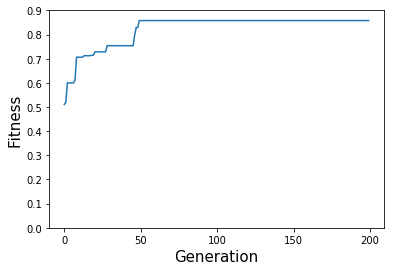

In [12]:
plt.plot(accuracies)
plt.xlabel("Generation", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.xticks(np.arange(0, num_generations+1, 50))
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

### Test predictions

In [13]:
weights_mat = vector_to_mat(weights_vector, weights_mat)
best_weights = weights_mat [0, :]
acc, predictions = predict(x_test, y_test, best_weights, sigmoid)
print("Accuracy of the best solution is : ", acc)

Accuracy of the best solution is :  0.8564397046759639


### Resources

https://www.linkedin.com/pulse/introduction-optimization-genetic-algorithm-ahmed-gad/ <br>
https://www.kdnuggets.com/2018/03/introduction-optimization-with-genetic-algorithm.html <br>
https://towardsdatascience.com/introduction-to-optimization-with-genetic-algorithm-2f5001d9964b <br>
https://www.springer.com/us/book/9781484241660 